In [2]:
# Inputs: image, a 3d numpy array of size NxMx3, where the 3rd dimension is for the colour channels.
# Outputs: an array of size NxM containing the energies
import numpy as np
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
import sys
%matplotlib inline
# Computes the "energy" of an image, using the Laplacian of each colour channel and summing them up.
# Inputs: image, a 3d numpy array of size NxMx3
# Outputs: the energy image, a 2d numpy array of size NxM
def energy(image):
    dy = np.array([-1, 0, 1])[:,None,None]
    dx = np.array([-1, 0, 1])[None,:,None]
    energy_img = convolve(image, dx)**2 + convolve(image, dy)**2
    return np.sum(energy_img, axis=2)


# Find the minimum-energy horizontal seam in an image.
# Inputs: energy, a 2d numpy array containing the energy values. Size NxM.
# Outputs: a seam represented as a 1d array of length M, with all values
# between 0 and N-1.

def find_horizontal_seam(energy):
    return find_vertical_seam(energy.T)






# Remove a vertical seam from an image:
# Inputs: image, a 2d numpy array containing the pixel values. Size NxM.
# seam, a 1d array (or list) containing the column index of each pixel in the seam. 
# Length N, all values between 0 and M-1.
# Outputs: a new image that is smaller by 1 column. Size N by M-1.
def remove_vertical_seam(image, seam):
    height = image.shape[0]
    linear_inds = np.array(seam)+np.arange(image.shape[0])*image.shape[1]
    new_image = np.zeros((height,image.shape[1]-1,3), dtype="uint8")
    for c in range(3):
        temp = np.delete(image[:,:,c], linear_inds.astype(int))
        temp = np.reshape(temp, (height, image.shape[1]-1))
        new_image[:,:,c] = temp
    return new_image


# Same as remove_vertical_seam above, but for a horizontal seam. The output
# image is size N-1 by M.

def remove_horizontal_seam(image, seam):
    return np.transpose(remove_vertical_seam(np.transpose(image,(1,0,2)),seam), (1,0,2))


# Resize an NxM image to a desired height and width.
# Note: this function only makes images smaller. Enlarging an image is not implemented.
# Inputs: image, a 3d numpy array of size NxMx3
# desired_width, an integer giving the desired width
# desired_height, an integer giving the desired height
# Outputs: the resized image, now of size N x desired_width x 3

def seam_carve(image, desired_height, desired_width):
    while image.shape[1] > desired_width:
        seam = find_vertical_seam(energy(image))
        assert len(seam) == image.shape[0], "the length of the seam must equal the height of the image"
        image = remove_vertical_seam(image, seam)
        sys.stdout.write('\rWidth is now %d' % image.shape[1])
    print()
    while image.shape[0] > desired_height:
        seam = find_horizontal_seam(energy(image))
        assert len(seam) == image.shape[1], "the length of the seam must equal the width of the image"
        image = remove_horizontal_seam(image, seam)
        sys.stdout.write('\rHeight is now %d' % image.shape[0])
    print()
    return image




In [3]:
def find_vertical_seam(energy):
    costs = dict()
    for i in range(energy.shape[1]):
        best_seam, best_cost = fvs(energy, [i], 0.0)
        costs[tuple(best_seam)] = best_cost
    return min(costs, key=costs.get) # the best out of the M best seams


def fvs(energy, seam, cost):
    row = len(seam)-1
    col = seam[-1]
    # if out of bounds on one of the two sides, return infinite energy
    if col < 0 or col >= energy.shape[1]:
        return seam, np.inf
    cost += energy[row,col]
    # regular base case: reached bottom of image
    if len(seam) == energy.shape[0]:
        return seam, cost
    return min((fvs(energy, seam+[col], cost),
    fvs(energy, seam+[col+1],cost),
    fvs(energy, seam+[col-1],cost)),key=lambda x:x[1])
    # above: could make syntax nicer if I was willing to tolerate some more inefficiency
    # by defining an energy function of seam and re-computing energy of theseam each time

## PART 1    
    
## Question 1 
## The time complexity of the exhaustive algorith is O(n*(3^(2*m)))
## Where m is rows and n is columns
    
    
## Question 2 
## The Largest square image you can remove a SINGLE VERTICAL seam(NO HORIZONTAL SEAM) from within 10 seconds is 13x13

In [4]:
## PART 2

# Given an energy matrix, this function transforms it into a vertical Energy Table 
# containing the minimum energy to reach that position from the top
def getVerticalEnergyTable(energy):
    energyTable = energy
    for row in range(energy.shape[0]):
        for col in range(energy.shape[1]):
            ## Boundary Checking 
            if (row != 0):
                if (col == 0):
                    energyTable[row,col] +=  min(energyTable[row-1,col],energyTable[row-1,col+1])
                elif (col == energy.shape[1]-1):
                    energyTable[row,col] +=  min(energyTable[row-1,col-1],energyTable[row-1,col])
                else:
                    energyTable[row,col] +=  min(energyTable[row-1,col-1],energyTable[row-1,col],energyTable[row-1,col+1])
    return energyTable

def find_vertical_seam(energy):
    
    table = getVerticalEnergyTable(energy)
    # Getting the index of the minimum value from the energy table
    minCostIndex = np.argmin(table[table.shape[0]-1])
    indices = np.empty(table.shape[0],dtype=int)
    
    # The index of the last element in the seam is decided through the energy table
    indices[table.shape[0]-1] = minCostIndex
    
    # Iterating from bottom to top to find the path of the minimum cost
    for i in range(table.shape[0]-2,-1,-1):
        
        # Adding minCostIndex to each result because argmin would give index starting from 0 since we spliced the arrays
        if (minCostIndex == 0):
            minCostIndex = np.argmin(table[i,minCostIndex:minCostIndex+2]) + minCostIndex
        elif (minCostIndex == table.shape[1]-1):
            minCostIndex = np.argmin(table[i,minCostIndex-1:minCostIndex+1]) + (minCostIndex-1)
        else:
            minCostIndex = np.argmin(table[i,minCostIndex-1:minCostIndex+2]) + (minCostIndex-1)
        indices[i] = minCostIndex
    return indices


## Time Complexity
##  = O(height*width)



(612, 620, 3)
Width is now 614

KeyboardInterrupt: 

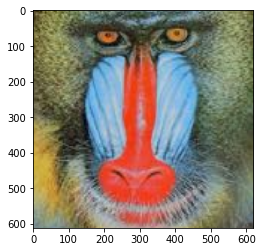

In [5]:
## Generating a random image and testing on it

np.random.seed(1)
h = 10
w = 10
img = np.random.randint(0,255,(h,w,3)).astype("uint8")
img = plt.imread('monkey.jpg')
h = img.shape[0]
w = img.shape[1]
print(img.shape)
plt.figure()
plt.imshow(img)
e = energy(img)
# plt.imshow(e)
# print(e)
# img2 = 
img2 = seam_carve(img, h, w-100)
plt.figure()
plt.imshow(img2);


[0 0 0 0 0 0 0 0 0 0]
